## A Comparative Study of Feature Representations for Machine Learning-Based Peptide RT Prediction

### Motivation
Understanding peptide retention time (RT) in liquid chromatography is crucial for enhancing peptide identification and separation. Peptide RT refers to the time it take to elude from a liquid chromatography column. RT is primarily determined by peptide hydrophobicity, sequence, and other physicochemical properties. I chose this topic as a learning exercise to explore fundamental aspects of feature representation of peptide in machine learning to predict RT of experimental dataset. Since both peptide sequence and chemistry influence peptide properties like RT, it is worthwhile to investigate how simple sequence- and chemistry-based feature representations can improve model performance. In this context, starting with a basic amino acid count-based approach for peptide RT prediction provides a useful foundation. Additionally, examining how data dimensionality impacts predictive performance may offer further insights.

### Dataset
I used two datasets from the [PepMNet RT Data repository](https://github.com/danielgarzonotero/PepMNet/tree/main/data/RT):  

| Dataset | LC Type | Number of Peptides |
|---------|---------|------------------|
| HeLa    | RPLC    | 1,170            |
| Yeast   | RPLC    | 14,361           |

These datasets contain peptides composed of natural amino acids, measured using reversed-phase liquid chromatography (RPLC). RPLC separates peptides based on hydrophobic interactions with a stationary phase, making the data particularly suitable for studying sequence- and structure-based determinants of hydrophobicity and retention behavior.

### Goals
The project aims to investigate how effectively various machine learning methods can predict peptide retention time (RT) and to quantify the contribution of sequence‑based and physicochemical features. The specific objectives are:

1. Evaluate the influence of different feature representations on prediction accuracy, including:

    a. Sequence‑independent features: bag‑of‑words (BoW) with sequence length, and bag‑of‑words with sequence length plus physicochemical descriptors (BoW+PD) (e.g., net charge, aromaticity, hydrophobicity).

    b. Sequence‑dependent features: one‑hot encoding of amino acid sequences.

2. Assess the performance of multiple machine learning models: Linear Regression, Kernel Ridge Regression, and XGBoost—using each of the three feature representations for peptide RT prediction.

3. Benchmark these models against PepMNet, a pretrained hierarchical graph‑based model that incorporates both atom‑level and amino‑acid‑level information.



--- HeLa Dataset (df1) Head (First 10) ---
                                            sequence        RT
0                  DCDPTTGETDDEGYEDEYVLEDLEVTVADHIQK  6212.340
1     SSSQDSEVSTVVSNSSGETLGADSDLSSNAGDGPGGEGSVHLASSR  4808.466
2             DFDSERGLSISGEGGAFEQQAAGAVLDLMGDEAQNLTR  6254.580
3           YQGLQQQEAKPDGLVTDSSAELQSLEQQLEEAQTENFNIK  6151.260
4              SPVQEASSATDTDTNSQEDPADTASVSSLSLSTGHTK  4424.316
5          TETSEEGSGDLDNLDAILGDLTSSDFYNNSISSNGSHLGTK  6213.480
6              GAQAGTQVEEAEAEAVAVASGTAGGDDGGASGRPLPK  5683.008
7               LAQQQASAAAAAAAATAAATAATTTSAGVSHQNPSK  5547.396
8  AASAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAATK  2911.584
9           QSVNISLSGCQPAPEGYSPTLQWQQQQVAQFSTVRQNVNK  5845.482

--- Yeast Dataset (df2) Head (First 10) ---
                               sequence        RT
0           VSLDDLQQSIEEDEDHVQSTDIAAMQK  15083.40
1                 NVIAETGAGQHGVATATACAK   6098.04
2        FATVPTGGASSAAAGAAGAAAGGDAAEEEK   8934.06
3              LTP

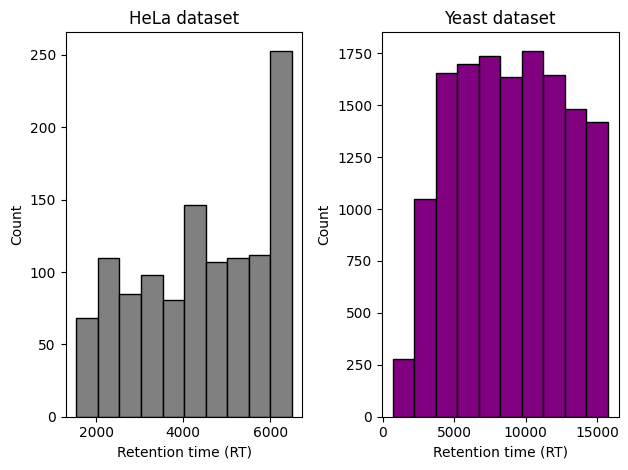

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt

df1 = pd.read_csv('hela_mod3.csv') 
df2 = pd.read_csv('yeast_unmod.csv') 

print("\n--- HeLa Dataset (df1) Head (First 10) ---")
print(df1.head(10))
print("\n--- Yeast Dataset (df2) Head (First 10) ---")
print(df2.head(10)) 
print(f"HeLa (df1) shape: {df1.shape}")
print(f"Yeast (df2) shape: {df2.shape}")

plt.subplot(1, 2, 1)
plt.hist(df1["RT"].values,edgecolor='black', color="grey")
plt.title("HeLa dataset")
plt.xlabel("Retention time (RT)")
plt.ylabel("Count")
plt.subplot(1, 2, 2)
plt.hist(df2["RT"].values, edgecolor='black', color="purple")
plt.title("Yeast dataset")
plt.xlabel("Retention time (RT)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Methods
I employed three machine learning algorithms to predict peptide retention time (RT):  

1. **Linear Regression (LR):** A simple baseline model to assess linear relationships between features and RT.  
2. **Kernel Ridge Regression (KRR):** Captures non-linear relationships using kernel functions, suitable for complex feature interactions.   
3. **XGBoost:** A gradient boosting algorithm that often achieves high predictive performance on structured data, robust to overfitting and feature redundancy.  

**Note:** 
I used the **same train test split as in the PepMnet paper for fair comparision between models**. The training and testing data along with PepMnet predicted data is available in 'results/RT/{name_dataset}_training_set_prediction.xlsx' and 'results/RT/{name_dataset}_test_set_prediction.xlsx'

These methods are chosen because the dataset contains both small (HeLa, 1,170 peptides) and large (Yeast, 14,361 peptides) sample sizes with diverse features, ranging from simple amino acid counts to complex physicochemical descriptors. LR provides a baseline, while KRR, and XGBoost can capture non-linear and interaction effects that are expected in peptide sequence and structural features.

### Free Parameters and Hyperparameter Optimization
- **Linear Regression:** No hyperparameters; free parameters are the regression coefficients, fitted using ordinary least squares.  
- **Kernel Ridge Regression:** Hyperparameters include the regularization parameter (`alpha`) and kernel parameters (e.g., `gamma` for RBF kernel).  
- **XGBoost:** Hyperparameters include learning rate (`eta`), maximum depth (`max_depth`), number of boosting rounds (`n_estimators`), subsample ratios, and regularization terms (`lambda`, `alpha`).  

Hyperparameters are optimized using cross-validation and grid search or randomized search, selecting values that maximize predictive performance on validation subsets. Features are scaled or normalized when required to ensure proper model convergence and performance.


## Results
### Feature Extraction and CSV Export

The script below processes peptide sequence datasets (`hela_mod3` and `yeast_unmod`) to create numerical features for ML models. It generates a **bag-of-words (BoW) representation** of sequences, adds **sequence length** as a feature, and combines these with the target retention times. The resulting training and test sets are saved as CSV files in `saved_csv_features/` for downstream modeling.


In [2]:
import time
import numpy as np
import pandas as pd
import os
import json

from sklearn.feature_extraction.text import CountVectorizer

start_time = time.time()
datasets = ['hela_mod3', 'yeast_unmod']

save_dir = "saved_csv_features"
os.makedirs(save_dir, exist_ok=True)

for data in datasets:
    train_path = f'results/RT/{data}_training_set_prediction.xlsx'
    test_path = f'results/RT/{data}_test_set_prediction.xlsx'
    train_df = pd.read_excel(train_path)
    test_df = pd.read_excel(test_path)
    
    print(f"\n Dataset: {data}")
    print(f"Train dataset: {len(train_df):,} | Test dataset: {len(test_df):,}")
    
    # Vectorizer
    vectorizer = CountVectorizer(analyzer='char', lowercase=False)
    X_train_counts = vectorizer.fit_transform(train_df['Sequence']).toarray()
    X_test_counts  = vectorizer.transform(test_df['Sequence']).toarray()

    # Add sequence length as a feature
    get_phys_features = lambda seqs: np.array([[len(s)] for s in seqs])
    X_train = np.hstack([X_train_counts, get_phys_features(train_df['Sequence'])])
    X_test  = np.hstack([X_test_counts,  get_phys_features(test_df['Sequence'])])

    y_train = train_df['Target'].values
    y_test  = test_df['Target'].values

    print(f"Feature matrix → Train: {X_train.shape} | Test: {X_test.shape}")

    #  COMBINE X + y INTO ONE CSV 
    train_combined = np.hstack([X_train, y_train.reshape(-1, 1)])
    test_combined  = np.hstack([X_test,  y_test.reshape(-1, 1)])

    # Create column names
    num_features = X_train.shape[1]
    columns = [f"f{i}" for i in range(num_features)] + ["Target"]

    # Save CSV files
    pd.DataFrame(train_combined, columns=columns).to_csv(
        f"{save_dir}/{data}_train.csv", index=False
    )

    pd.DataFrame(test_combined, columns=columns).to_csv(
        f"{save_dir}/{data}_test.csv", index=False
    )

    print(f"Saved CSV files → {data}_train.csv and {data}_test.csv")
df_hela = pd.read_csv('saved_csv_features/hela_mod3_train.csv') 
print("\n--- HeLa Dataset (df) Head (First 5) ---")
print(df_hela.head(5))




 Dataset: hela_mod3
Train dataset: 1,053 | Test dataset: 117
Feature matrix → Train: (1053, 21) | Test: (117, 21)
Saved CSV files → hela_mod3_train.csv and hela_mod3_test.csv

 Dataset: yeast_unmod
Train dataset: 12,924 | Test dataset: 1,437
Feature matrix → Train: (12924, 21) | Test: (1437, 21)
Saved CSV files → yeast_unmod_train.csv and yeast_unmod_test.csv

--- HeLa Dataset (df) Head (First 5) ---
    f0   f1   f2   f3   f4   f5   f6   f7   f8   f9  ...  f12  f13  f14   f15  \
0  4.0  0.0  6.0  4.0  2.0  2.0  1.0  0.0  1.0  1.0  ...  5.0  4.0  0.0   9.0   
1  4.0  0.0  3.0  4.0  0.0  2.0  0.0  1.0  1.0  4.0  ...  0.0  1.0  1.0   2.0   
2  2.0  1.0  3.0  1.0  0.0  1.0  1.0  3.0  1.0  4.0  ...  0.0  3.0  0.0   4.0   
3  2.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  2.0  ...  5.0  2.0  0.0  12.0   
4  3.0  0.0  3.0  3.0  2.0  1.0  0.0  1.0  1.0  1.0  ...  0.0  2.0  0.0   1.0   

   f16  f17  f18  f19   f20       Target  
0  1.0  0.0  0.0  1.0  41.0  4842.209961  
1  3.0  4.0  0.0  0.0 

**Note**: CSV file reading guide:\
Vocabulary = A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y \
the column f0-f19 contains count of each amino acid in peptide sequence according to the vocabulary above, and f20 is the length of peptide sequence.

### Feature Scaling and Covariance Analysis

The script below loads the preprocessed training and test CSV files for `hela_mod3` and separates features (`X`) from targets (`y`). The features are **standardized** using the training set mean and standard deviation. It then computes the **covariance matrix** of the scaled training features, visualizes it as a heatmap, and identifies the pair of features with the **maximum covariance** (excluding the diagonal) to highlight the strongest linear relationship between features.


Dataset: hela_mod3
Max covariance at indices: (16, 20)
Max covariance value: 0.5799454309184652
Features with strongest linear relationship: f16 and f20

Dataset: yeast_unmod
Max covariance at indices: (5, 20)
Max covariance value: 0.42612394196072007
Features with strongest linear relationship: f5 and f20



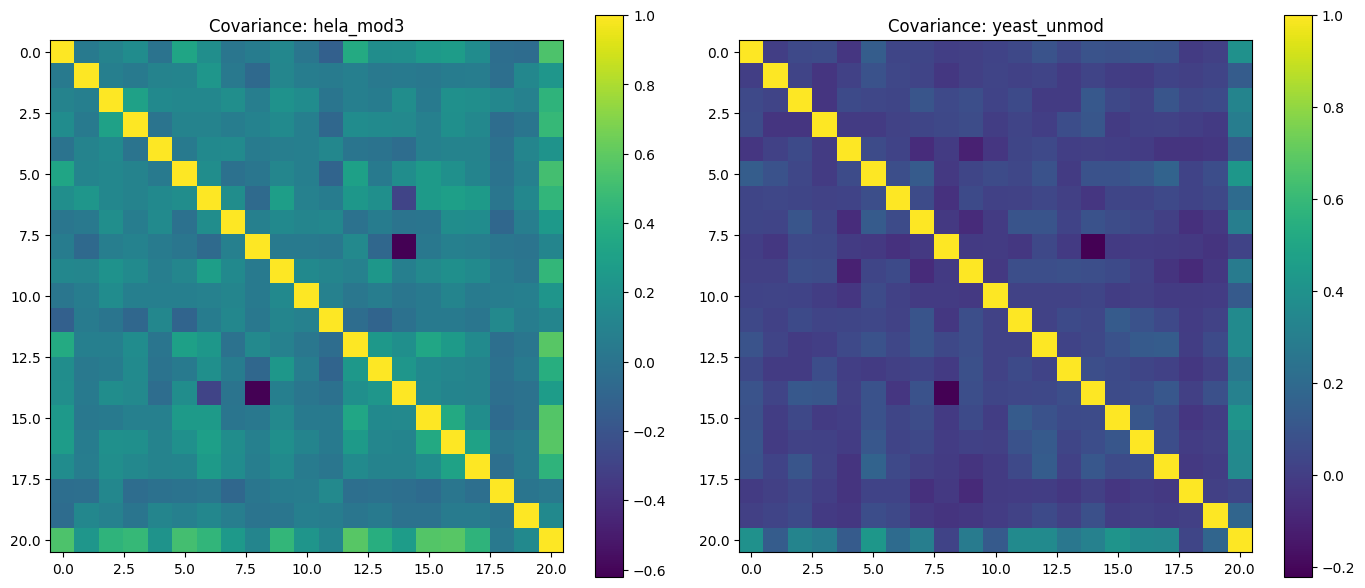

In [3]:

datasets = ['hela_mod3', 'yeast_unmod']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

for i, data in enumerate(datasets):
    # Load CSV
    train_path = f'saved_csv_features/{data}_train.csv'
    test_path  = f'saved_csv_features/{data}_test.csv'
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    # Extract features and targets
    X_train = train_df.iloc[:, :-1].values.astype(float)
    y_train = train_df.iloc[:, -1].values.astype(float)
    X_test  = test_df.iloc[:, :-1].values.astype(float)
    y_test  = test_df.iloc[:, -1].values.astype(float)

    # Standard scaling based on training data
    train_mean = X_train.mean(axis=0)
    train_std  = X_train.std(axis=0)
    X_train = (X_train - train_mean) / train_std
    X_test  = (X_test  - train_mean) / train_std

    # Compute covariance matrix
    covar = np.cov(X_train.T)
    # np.fill_diagonal(covar, 0)

    # Plot covariance heatmap
    cax = axes[i].imshow(covar, cmap='viridis')
    axes[i].set_title(f'Covariance: {data}')
    fig.colorbar(cax, ax=axes[i])

    # Find maximum covariance
    np.fill_diagonal(covar, 0)
    flat_index = np.argmax(covar)
    row_index, col_index = np.unravel_index(flat_index, covar.shape)
    feature_names = train_df.columns[:-1]

    print(f"Dataset: {data}")
    print(f"Max covariance at indices: ({row_index}, {col_index})")
    print(f"Max covariance value: {covar[row_index, col_index]}")
    print(f"Features with strongest linear relationship: {feature_names[row_index]} and {feature_names[col_index]}\n")

plt.tight_layout()
plt.show()


The above covariance plot is used to visualize the feature scaling and also look at the correlated features. Note that, I am not discarding any correlated feature here.

In this step, we augment the original peptide features (f0–f20) with **three additional RDKit-derived features** for each sequence:

1. **Net Charge** – Approximate net charge at physiological pH (~7), calculated as the difference between positively charged residues (Arg, Lys, His) and negatively charged residues (Asp, Glu).

2. **Aromatic Atoms** – Count of aromatic atoms in the peptide (F, Y, W, H), reflecting potential π-interactions.

3. **Average Hydrophobicity** – Mean hydrophobicity of amino acids using the Kyte-Doolittle scale.

These features are computed for both **training** and **test datasets** (`hela_mod3` and `yeast_unmod`) and appended to the original CSV files.  

The resulting files (`*_train_rdkit.csv` and `*_test_rdkit.csv`) now contain:  

- Original 21 features (f0–f20)  
- 3 selected RDKit-based features  
- Target variable (retention time)  

This enhanced feature set is intended to provide more chemically relevant information for machine learning models such as **Linear Regression, KRR, and XGBoost**.


In [4]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

datasets = ['hela_mod3', 'yeast_unmod']
save_dir = "saved_csv_features"
os.makedirs(save_dir, exist_ok=True)

# Hydrophobicity dictionary (Kyte-Doolittle scale)
hydro_dict = {
    "A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
    "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
    "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
    "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2
}

# Function to compute only the 4 selected features
def calc_selected_features(seq):
    try:
        mol = Chem.MolFromSequence(seq)
        if mol is None:
            return [0.0] * 4
        
        
        # 1. Approximate net charge at pH ~7 (common in proteomics)
        #    Arg, Lys, His = +1; Asp, Glu = -1; others 0
        num_arg = seq.count('R')
        num_lys = seq.count('K')
        num_his = seq.count('H')
        num_asp = seq.count('D')
        num_glu = seq.count('E')
        net_charge = (num_arg + num_lys + num_his) - (num_asp + num_glu)
        

        
        # 2. Number of aromatic atoms (F, Y, W, H rings)
        aromatic_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic())
        
        # 3. Average hydrophobicity
        avg_hydro = np.mean([hydro_dict.get(aa, 0) for aa in seq])
        
        return [net_charge, aromatic_atoms, avg_hydro]
    
    except:
        return [0.0] * 4  #

# Process datasets
for data in datasets:
    print(f"Processing dataset: {data}")

    # Read sequences from original Excel files
    train_excel = f'results/RT/{data}_training_set_prediction.xlsx'
    test_excel  = f'results/RT/{data}_test_set_prediction.xlsx'

    train_df_orig = pd.read_excel(train_excel)
    test_df_orig  = pd.read_excel(test_excel)

    # Load existing f0-f20 CSVs
    train_csv = pd.read_csv(f'saved_csv_features/{data}_train.csv')
    test_csv  = pd.read_csv(f'saved_csv_features/{data}_test.csv')

    for split, df_csv, df_orig in zip(
        ['train', 'test'],
        [train_csv, test_csv],
        [train_df_orig, test_df_orig]
    ):
        sequences = df_orig['Sequence'].values
        selected_features = np.array([calc_selected_features(seq) for seq in sequences])
        
        feature_names = ["NetCharge", "AromaticAtoms", "AvgHydrophobicity"]
        
        # Create DataFrame for the 4 selected features
        selected_df = pd.DataFrame(selected_features, columns=feature_names)

        # Concatenate: original features (f0-f20) + new 4 features + target (last column)
        df_final = pd.concat([df_csv.iloc[:, :-1], selected_df, df_csv.iloc[:, -1]], axis=1)

        # Ensure no NaNs
        df_final = df_final.fillna(0)

        # Save new CSV
        save_path = f"{save_dir}/{data}_{split}_rdkit.csv"
        df_final.to_csv(save_path, index=False)
        print(f"Saved {save_path}")

df_hela = pd.read_csv('saved_csv_features/hela_mod3_train_rdkit.csv') 
print("\n--- HeLa Dataset (df) Head (First 5) ---")
print(df_hela.head(5))

Processing dataset: hela_mod3
Saved saved_csv_features/hela_mod3_train_rdkit.csv
Saved saved_csv_features/hela_mod3_test_rdkit.csv
Processing dataset: yeast_unmod
Saved saved_csv_features/yeast_unmod_train_rdkit.csv
Saved saved_csv_features/yeast_unmod_test_rdkit.csv

--- HeLa Dataset (df) Head (First 5) ---
    f0   f1   f2   f3   f4   f5   f6   f7   f8   f9  ...   f15  f16  f17  f18  \
0  4.0  0.0  6.0  4.0  2.0  2.0  1.0  0.0  1.0  1.0  ...   9.0  1.0  0.0  0.0   
1  4.0  0.0  3.0  4.0  0.0  2.0  0.0  1.0  1.0  4.0  ...   2.0  3.0  4.0  0.0   
2  2.0  1.0  3.0  1.0  0.0  1.0  1.0  3.0  1.0  4.0  ...   4.0  1.0  0.0  0.0   
3  2.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  2.0  ...  12.0  2.0  1.0  1.0   
4  3.0  0.0  3.0  3.0  2.0  1.0  0.0  1.0  1.0  1.0  ...   1.0  2.0  3.0  0.0   

   f19   f20  NetCharge  AromaticAtoms  AvgHydrophobicity       Target  
0  1.0  41.0       -8.0           23.0          -1.402439  4842.209961  
1  0.0  30.0       -5.0            0.0           0.093333

In [5]:
import os
import time
import numpy as np
import pandas as pd

DATASETS   = ['hela_mod3', 'yeast_unmod']
BASE_DIR   = "results/RT"
SAVE_DIR   = "saved_csv_features"
SEQUENCE_COL = 'Sequence'
RT_COL       = 'Target'

AMINO_ACIDS = sorted("ACDEFGHIKLMNPQRSTVWY")
VOCAB_SIZE  = len(AMINO_ACIDS)

os.makedirs(SAVE_DIR, exist_ok=True)

def one_hot_encode(df, max_len):
    """Return (encoded_df, feature_matrix)"""

    num_samples = len(df)
    one_hot = np.zeros((num_samples, max_len, VOCAB_SIZE), dtype=np.int8)
    aa_to_idx = {aa: i for i, aa in enumerate(AMINO_ACIDS)}

    for row, seq in enumerate(df[SEQUENCE_COL]):
        for pos, aa in enumerate(seq):
            if aa in aa_to_idx:
                one_hot[row, pos, aa_to_idx[aa]] = 1

    feature_matrix = one_hot.reshape(num_samples, -1)
    col_names = [f"Pos{p+1}_{aa}" for p in range(max_len) for aa in AMINO_ACIDS]

    df_out = pd.DataFrame(feature_matrix, columns=col_names)
    df_out[RT_COL] = df[RT_COL].values

    return df_out, feature_matrix
def normalize_features(train_mat, test_mat):
    """Standardize features using train mean/std."""
    
    train_mean = train_mat.mean(axis=0)
    train_std  = train_mat.std(axis=0)
    
    # Avoid divide-by-zero
    train_std[train_std == 0] = 1.0
    
    train_norm = (train_mat - train_mean) / train_std
    test_norm  = (test_mat  - train_mean) / train_std
    
    return train_norm, test_norm
def process_dataset(name, normalize=True):
    print(f"\n=== Processing: {name} ===")

    train_path = f"{BASE_DIR}/{name}_training_set_prediction.xlsx"
    test_path  = f"{BASE_DIR}/{name}_test_set_prediction.xlsx"

    if not (os.path.exists(train_path) and os.path.exists(test_path)):
        print("✖ Missing dataset files → skipping.")
        return

    train_df = pd.read_excel(train_path)
    test_df  = pd.read_excel(test_path)

    max_len = max(
        train_df[SEQUENCE_COL].str.len().max(),
        test_df[SEQUENCE_COL].str.len().max()
    )

    # Encode
    train_encoded_df, train_mat = one_hot_encode(train_df, max_len)
    test_encoded_df,  test_mat  = one_hot_encode(test_df,  max_len)

    if normalize:
        train_mat, test_mat = normalize_features(train_mat, test_mat)
        print(f" Features normalized using z-score")

    # Replace encoded matrices while keeping RT column
    feature_cols = train_encoded_df.columns[:-1]
    train_encoded_df[feature_cols] = train_mat
    test_encoded_df[feature_cols]  = test_mat

    # Save
    train_out = os.path.join(SAVE_DIR, f"{name}_train_onehot_norm.csv")
    test_out  = os.path.join(SAVE_DIR, f"{name}_test_onehot_norm.csv")

    train_encoded_df.to_csv(train_out, index=False)
    test_encoded_df.to_csv(test_out,  index=False)

    print(f" Max peptide len: {max_len}")
    print(f" Feature dimension: {train_mat.shape[1]}")
    print(f" Saved → {train_out}")
    print(f" Saved → {test_out}")
start = time.time()

for ds in DATASETS:
    process_dataset(ds, normalize=True)

print(f"Saved normalized files in {SAVE_DIR}")
print(f"Total runtime: {time.time() - start:.1f}s")




=== Processing: hela_mod3 ===
 Features normalized using z-score
 Max peptide len: 50
 Feature dimension: 1000
 Saved → saved_csv_features/hela_mod3_train_onehot_norm.csv
 Saved → saved_csv_features/hela_mod3_test_onehot_norm.csv

=== Processing: yeast_unmod ===
 Features normalized using z-score
 Max peptide len: 38
 Feature dimension: 760
 Saved → saved_csv_features/yeast_unmod_train_onehot_norm.csv
 Saved → saved_csv_features/yeast_unmod_test_onehot_norm.csv
Saved normalized files in saved_csv_features
Total runtime: 11.7s


### Machine Learning model setup and performance matrices

This part of the project focuses on building and evaluating machine learning models for predicting peptide retention time. The workflow includes loading and scaling the data, training several models, and assessing their performance through both quantitative metrics and visual comparisons of predicted versus true values. Standard scaling is applied to ensure that all features contribute consistently across models, and evaluation metrics such as R², RMSE, and MAE are used to judge predictive accuracy.

Model development begins with a simple linear regression baseline to establish how well a purely linear relationship can capture retention time behavior. From there, the analysis incorporates more flexible approaches, including Kernel Ridge Regression with an RBF kernel, where hyperparameters are tuned through systematic search strategies. To explore the impact of non‑linear interactions and feature importance, the workflow then progresses to XGBoost, a tree‑based ensemble method known for strong performance in regression tasks. Its key parameters are optimized to achieve the best predictive results, following guidance from prior studies emphasizing the value of feature importance analysis.

Overall, this modular setup makes it straightforward to compare models, examine how different feature representations influence performance, and visualize results across multiple datasets.


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import xgboost as xgb


DATASETS = ['hela_mod3', 'yeast_unmod']
FEATURE_TYPES = ['', '_rdkit', '_onehot_norm']  

SAVE_DIR = "model_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Configuration Loaded.")


Configuration Loaded.


In [7]:

def load_and_scale(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = train_df.iloc[:, :-1].values.astype(float)
    y_train = train_df.iloc[:, -1].values.astype(float)

    X_test = test_df.iloc[:, :-1].values.astype(float)
    y_test = test_df.iloc[:, -1].values.astype(float)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


def evaluate_and_plot(model_name, dataset, feature_type, y_true, y_pred, ax):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n[{model_name}] {dataset}{feature_type}") 
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")

    ax.plot(y_true, y_pred, 'o', alpha=0.4)
    ax.plot(y_true, y_true, '-k')
    ax.set_title(f"{model_name}: {dataset}{feature_type}")
    ax.set_xlabel("True RT (s)")
    ax.set_ylabel("Predicted RT (s)")

# MODEL TRAINING FUNCTIONS

def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model


def train_krr(X_train, y_train, dataset):
    param_grid = {
        'alpha': np.logspace(-10, 3, 30),
        'gamma': np.logspace(-12, 3, 30),
        'kernel': ['rbf']
    }

    if dataset == 'hela_mod3':
        search = GridSearchCV(KernelRidge(), param_grid, cv=5, scoring='r2', n_jobs=-1) # 5 fold cross validation for smaller dataset
    else:
        search = RandomizedSearchCV(KernelRidge(), param_distributions=param_grid, # 2 fold cross validation for large dataset to save computational time
                                    n_iter=20, cv=2, scoring='r2', n_jobs=-1)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_


def train_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        random_state=42
    )
    param_grid = {                    # parameter optimization of xgboost
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }
    search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_



[Linear Regression] hela_mod3
R²:   0.8603
RMSE: 535.3189
MAE:  420.9336

[KRR] hela_mod3
R²:   0.9472
RMSE: 329.1739
MAE:  257.7862

[XGBoost] hela_mod3
R²:   0.9422
RMSE: 344.1814
MAE:  270.5780

[Linear Regression] yeast_unmod
R²:   0.8790
RMSE: 1313.9736
MAE:  1002.2247

[KRR] yeast_unmod
R²:   0.9193
RMSE: 1073.1246
MAE:  817.0827

[XGBoost] yeast_unmod
R²:   0.9160
RMSE: 1094.5656
MAE:  834.2108


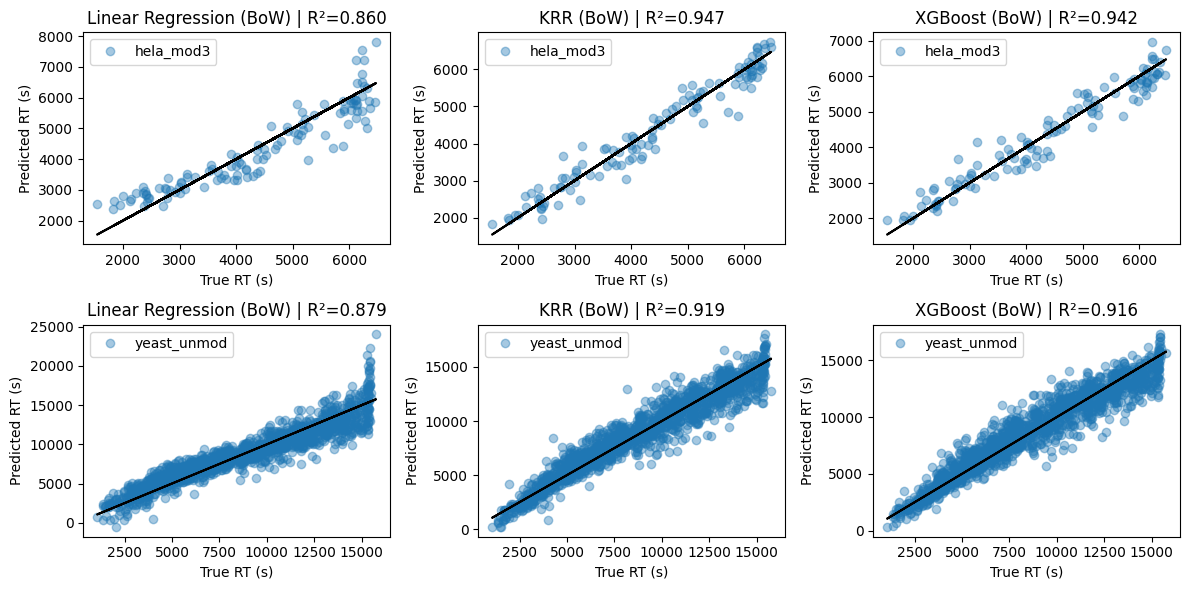


[Linear Regression] hela_mod3_rdkit
R²:   0.8763
RMSE: 503.6966
MAE:  389.5839

[KRR] hela_mod3_rdkit
R²:   0.9507
RMSE: 318.0847
MAE:  241.0996

[XGBoost] hela_mod3_rdkit
R²:   0.9481
RMSE: 326.2430
MAE:  260.3798

[Linear Regression] yeast_unmod_rdkit
R²:   0.8844
RMSE: 1283.8827
MAE:  976.7176

[KRR] yeast_unmod_rdkit
R²:   0.9218
RMSE: 1056.4694
MAE:  812.4246

[XGBoost] yeast_unmod_rdkit
R²:   0.9206
RMSE: 1064.0471
MAE:  813.1755


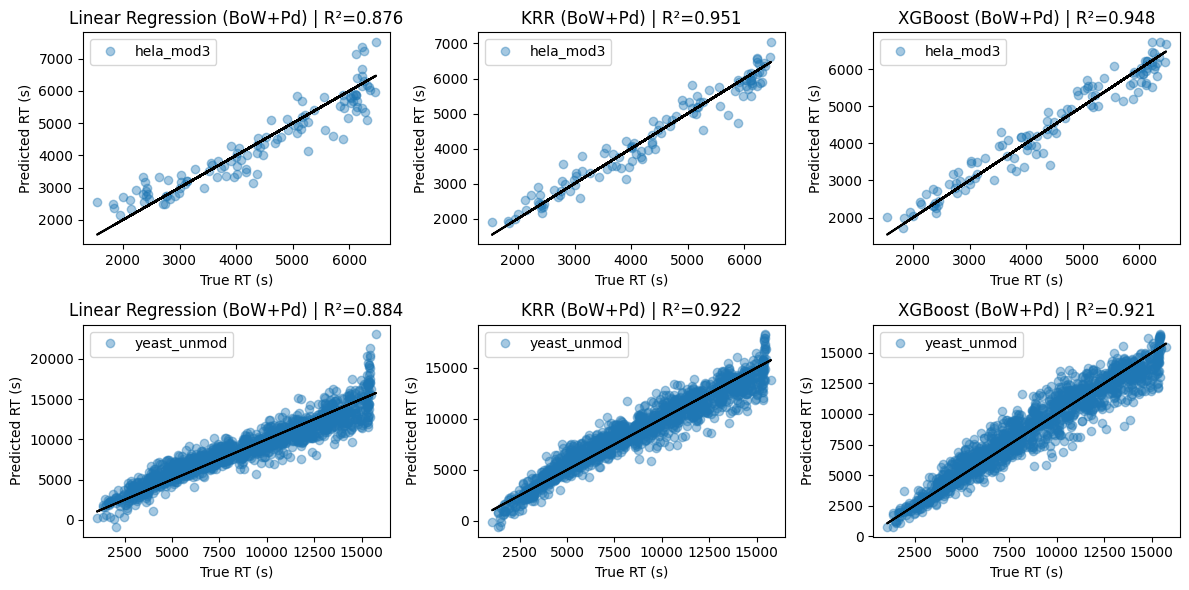


[Linear Regression] hela_mod3_onehot_norm
R²:   -27.0380
RMSE: 7583.4056
MAE:  2632.4592

[KRR] hela_mod3_onehot_norm
R²:   0.8152
RMSE: 615.6392
MAE:  500.7914

[XGBoost] hela_mod3_onehot_norm
R²:   0.7151
RMSE: 764.3791
MAE:  632.7109

[Linear Regression] yeast_unmod_onehot_norm
R²:   0.8948
RMSE: 1224.8464
MAE:  812.8638

[KRR] yeast_unmod_onehot_norm
R²:   0.9231
RMSE: 1047.6283
MAE:  779.5211

[XGBoost] yeast_unmod_onehot_norm
R²:   0.8360
RMSE: 1529.4485
MAE:  1211.1254


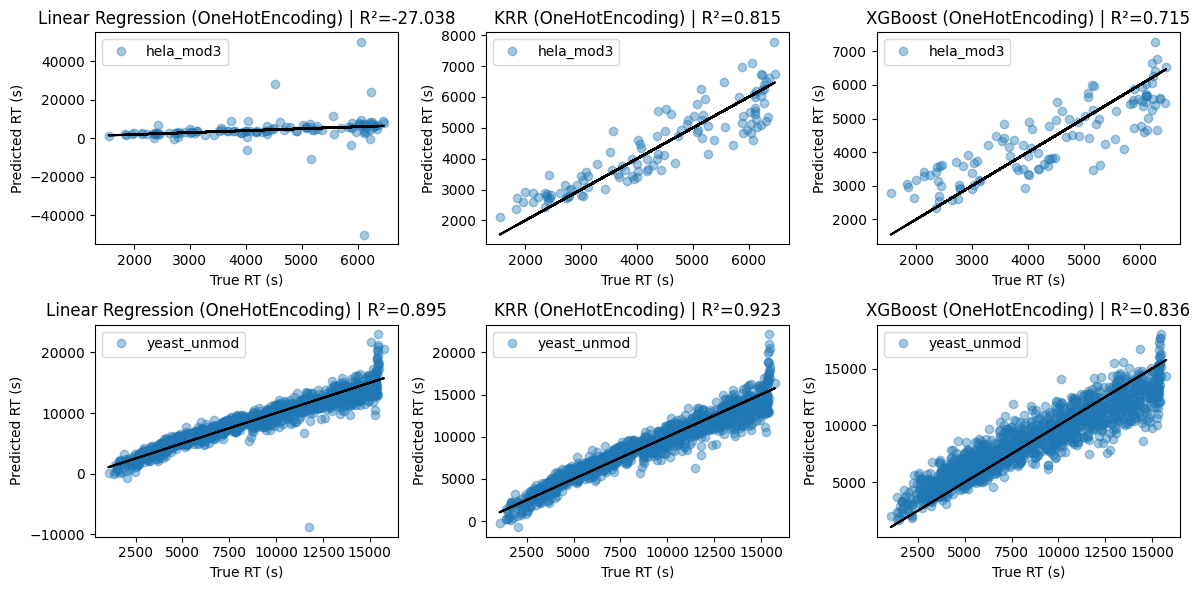

GNN (hela_mod3) -> R2=0.9498 | MAE=248.4913
GNN (yeast_unmod) -> R2=0.9818 | MAE=381.7700
done!


In [8]:
results = []   # store performance

# Map feature suffixes to display names
feature_name_map = {"": "BoW", "_rdkit": "BoW+Pd", "_onehot_norm": "OneHotEncoding"}

for feature in FEATURE_TYPES:

    fig, axes = plt.subplots(len(DATASETS), 3, figsize=(12, 3 * len(DATASETS)))

    for row, dataset in enumerate(DATASETS):

        train_path = f"saved_csv_features/{dataset}_train{feature}.csv"
        test_path = f"saved_csv_features/{dataset}_test{feature}.csv"

        if not os.path.exists(train_path):
            print(f"Skipping {train_path} (not found)")
            continue

        # Load & scale data
        X_train, X_test, y_train, y_test, scaler = load_and_scale(train_path, test_path)

        peptide_repr = feature_name_map.get(feature, feature)

        # Linear Regression
        lr = train_linear_regression(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        r2_lr = r2_score(y_test, y_pred_lr)
        evaluate_and_plot("Linear Regression", dataset, feature, y_test, y_pred_lr, axes[row, 0])
        axes[row, 0].set_title(f"Linear Regression ({peptide_repr}) | R²={r2_lr:.3f}")
        axes[row, 0].legend([dataset])

        results.append({
            "Dataset": dataset,
            "Feature_Type": peptide_repr,
            "Model": "Linear Regression",
            "R2": r2_lr,
            "MAE": mean_absolute_error(y_test, y_pred_lr),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lr))
        })

        # KRR
        krr, best_params = train_krr(X_train, y_train, dataset)
        y_pred_krr = krr.predict(X_test)
        r2_krr = r2_score(y_test, y_pred_krr)
        evaluate_and_plot("KRR", dataset, feature, y_test, y_pred_krr, axes[row, 1])
        axes[row, 1].set_title(f"KRR ({peptide_repr}) | R²={r2_krr:.3f}")
        axes[row, 1].legend([dataset])

        # Save model + scaler
        joblib.dump(krr, f"{SAVE_DIR}/krr_{dataset}{feature}.pkl")
        np.savez(f"{SAVE_DIR}/scaler_{dataset}{feature}.npz",
                 mean=scaler.mean_, scale=scaler.scale_)

        results.append({
            "Dataset": dataset,
            "Feature_Type": peptide_repr,
            "Model": "KRR",
            "R2": r2_krr,
            "MAE": mean_absolute_error(y_test, y_pred_krr),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_krr))
        })

        # XGBoost
        xgb_model, xgb_params = train_xgboost(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        r2_xgb = r2_score(y_test, y_pred_xgb)
        evaluate_and_plot("XGBoost", dataset, feature, y_test, y_pred_xgb, axes[row, 2])
        axes[row, 2].set_title(f"XGBoost ({peptide_repr}) | R²={r2_xgb:.3f}")
        axes[row, 2].legend([dataset])

        results.append({
            "Dataset": dataset,
            "Feature_Type": peptide_repr,
            "Model": "XGBoost",
            "R2": r2_xgb,
            "MAE": mean_absolute_error(y_test, y_pred_xgb),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        })

    plt.tight_layout()
    plt.show()


# GNN (PepMNet) performance
for dataset in DATASETS:
    train_df = pd.read_excel(f'results/RT/{dataset}_training_set_prediction.xlsx')
    test_df  = pd.read_excel(f'results/RT/{dataset}_test_set_prediction.xlsx')

    gnn_r2   = r2_score(test_df['Target'], test_df['Prediction'])
    gnn_mae  = mean_absolute_error(test_df['Target'], test_df['Prediction'])
    gnn_rmse = np.sqrt(mean_squared_error(test_df['Target'], test_df['Prediction']))

    results.append({
        "Dataset": dataset,
        "Feature_Type": "GNN",
        "Model": "GNN (PepMNet)",
        "R2": gnn_r2,
        "MAE": gnn_mae,
        "RMSE": gnn_rmse
    })

    print(f"GNN ({dataset}) -> R2={gnn_r2:.4f} | MAE={gnn_mae:.4f}")

print("done!")


The three sets of figures illustrate model performance across different feature representations. The first set evaluates predictions using the bag-of-words (BoW) approach, while the second incorporates additional physicochemical descriptors, such as, net charge, aromaticity, and hydrophobicity, alongside BoW (BoW+PD). The third set examines a sequence-dependent representation using one-hot encoding, which captures positional information but results in a substantially higher-dimensional feature space.

Linear Regression performs reasonably well for BoW and BoW+PD but struggles with one-hot encoding due to the high dimensionality combined with the limited size of the smaller dataset. KRR demonstrates strong performance across most representations, though its accuracy drops for one-hot encoding on the short dataset. XGBoost also yields competitive results but shows reduced performance when handling high-dimensional feature representations, particularly with one-hot encoding.

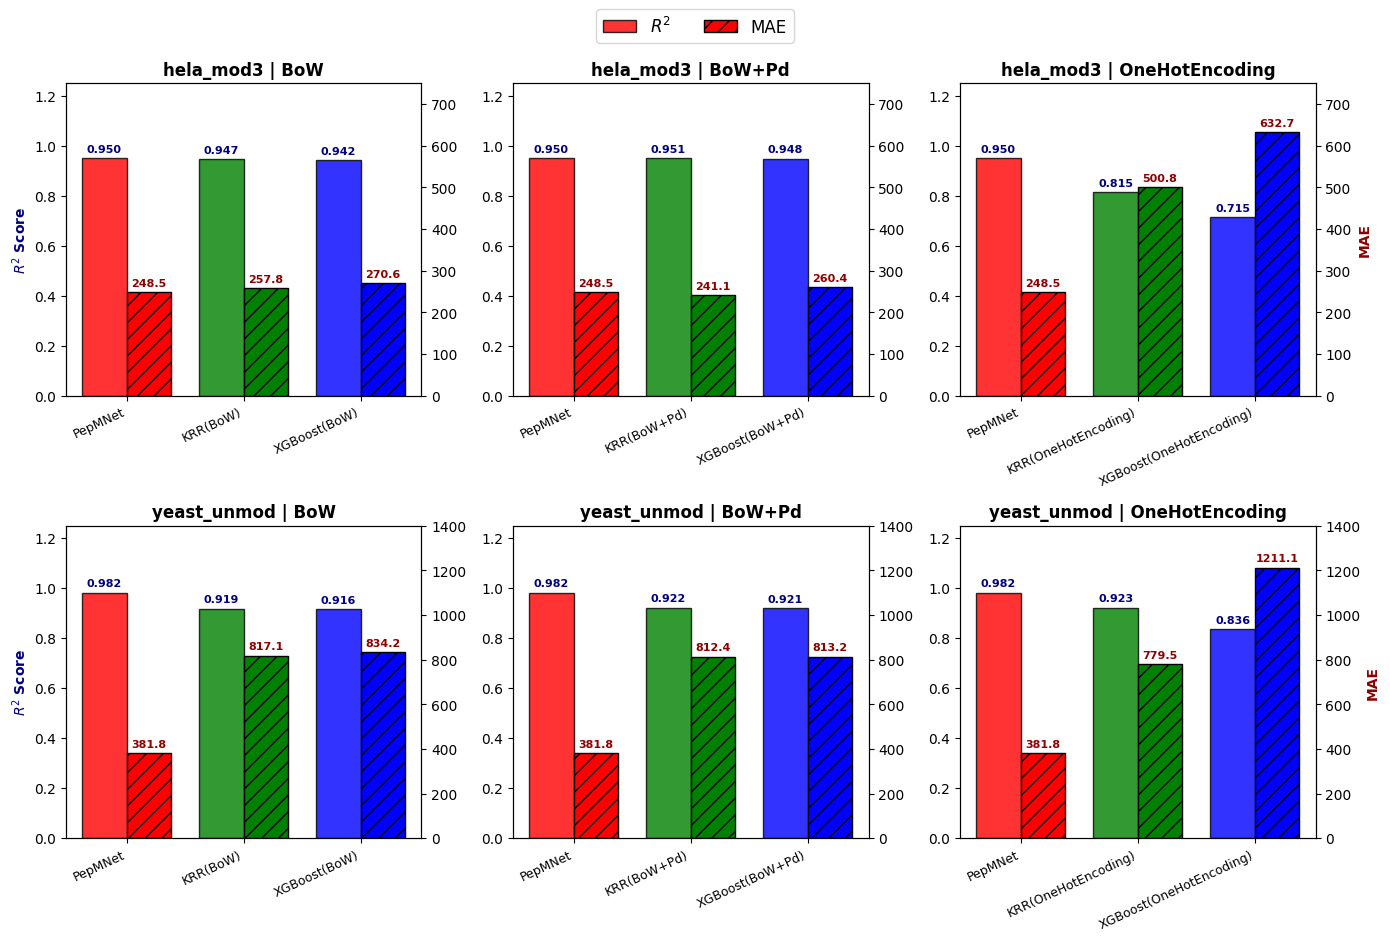

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


results_df = pd.DataFrame(results)

target_datasets = ["hela_mod3", "yeast_unmod"] 
feature_types = ["BoW", "BoW+Pd", "OneHotEncoding"]
output_dir = "final_plots"
os.makedirs(output_dir, exist_ok=True)

mae_limits = {
    "hela_mod3": (0, 750),
    "yeast_unmod": (0, 1400)
}

# Color Map
color_map = {
    "GNN (PepMNet)": "red",
    "KRR": "green",
    "XGBoost": "blue"
}

# Create a figure: 2 rows (Datasets), 3 columns (Feature Types)
fig, axes = plt.subplots(len(target_datasets), len(feature_types), 
                         figsize=(14, 9), sharex=False)

for row_idx, dataset in enumerate(target_datasets):
    dataset_df = results_df[results_df["Dataset"] == dataset]
    
    if dataset_df.empty:
        print(f"⚠️ Warning: No data found for dataset '{dataset}'.")
        continue

    # Pre-fetch GNN results for this dataset
    gnn_data = dataset_df[dataset_df["Model"] == "GNN (PepMNet)"]

    for col_idx, feat in enumerate(feature_types):
        ax1 = axes[row_idx, col_idx]
        
        # Filter classical models for this specific feature
        classical_df = dataset_df[
            (dataset_df["Feature_Type"] == feat) & 
            (dataset_df["Model"].isin(["KRR", "XGBoost"]))
        ].copy()
        
        # Combine with GNN
        df_plot = pd.concat([classical_df, gnn_data]).copy()
        
        order = ["GNN (PepMNet)", "KRR", "XGBoost"]
        df_plot["Model"] = pd.Categorical(df_plot["Model"], categories=order, ordered=True)
        df_plot = df_plot.sort_values("Model")

        if df_plot.empty:
            continue

        # Create secondary axis
        ax2 = ax1.twinx()
        
        x = np.arange(len(df_plot))
        width = 0.38 
        
        # Generate dynamic labels and colors
        bar_colors = [color_map.get(m, "gray") for m in df_plot["Model"]]
        custom_labels = ["PepMNet" if "GNN" in m else f"{m}({feat})" for m in df_plot["Model"]]

        # ax1: R2 (Solid)
        rects1 = ax1.bar(x - width/2, df_plot["R2"], width, 
                         color=bar_colors, alpha=0.8, edgecolor='black', label='$R^2$')
        
        # ax2: MAE (Hatched)
        rects2 = ax2.bar(x + width/2, df_plot["MAE"], width, 
                         color=bar_colors, alpha=1, edgecolor='black', hatch='//', label='MAE')


        ax1.bar_label(rects1, padding=3, fmt='%.3f', fontsize=8, fontweight='bold', color='navy')
        
        ax2.bar_label(rects2, padding=3, fmt='%.1f', fontsize=8, fontweight='bold', color='darkred')

        ax1.set_ylim(0, 1.25)  # Extra room for labels
        limit = mae_limits.get(dataset, (0, 1000))
        ax2.set_ylim(limit)

        # --- Formatting ---
        ax1.set_title(f"{dataset} | {feat}", fontsize=12, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(custom_labels, rotation=25, ha='right', fontsize=9)
        
        if col_idx == 0:
            ax1.set_ylabel("$R^2$ Score", fontweight='bold', color='navy')
        if col_idx == 2:
            ax2.set_ylabel("MAE", fontweight='bold', color='darkred')

# Global Legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', 
           bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)

plt.tight_layout()
plt.savefig(f"{output_dir}/final_comparison_with_labels.png", dpi=300, bbox_inches='tight')
plt.show()

The plots above summarize model performance across different feature representation strategies and benchmark them against the state-of-the-art graph neural network approach, PepMNet. Since all models were trained and tested on the same dataset splits, the comparison across representations and algorithms is fair and directly interpretable. Interestingly, although PepMNet employs a more sophisticated and expressive sequence‑aware representation, the simpler BoW and BoW+PD feature sets still deliver strong predictive performance in many scenarios. This indicates that, for these datasets, the primary determinants of retention time may already be well captured by composition‑based descriptors and basic physicochemical properties. Nevertheless, we anticipate that more advanced architectures will ultimately offer superior performance by better modeling the nonlinear and complex relationships inherent in the data.

## Conclusions
The results demonstrate that PepMNet generally delivers the strongest performance across datasets; however, simpler feature representations, particularly BoW and BoW+PD, achieve surprisingly comparable accuracy, especially on the smaller hela_mod3 dataset. In contrast, high-dimensional one-hot encoding performs poorly on limited data but improves substantially on the larger yeast_unmod dataset, highlighting how dataset size and representation complexity jointly influence model performance. Compared to prior literature, where graph-based models typically outperform traditional machine learning approaches, our findings suggest that composition-based representations can still be often competitive when physicochemical descriptors are included.

Overall, we met the primary goals of evaluating how different feature representations influence prediction accuracy and benchmarking multiple machine learning models—Linear Regression, KRR, and XGBoost—across those representations. Moving forward, expanding the set of physicochemical descriptors, applying dimensionality reduction or feature selection for one-hot encoding, and incorporating larger or more diverse peptide datasets could further improve performance and help identify key features governing retention time.

## References

1. Otero, D. G., Akbari, O., & Bilodeau, C. (2025). PepMNet: a hybrid deep learning model for predicting peptide properties using hierarchical graph representations. Molecular Systems Design & Engineering, 10(3), 205-218.
